In [11]:
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr, f_oneway

# Download latest version
path = kagglehub.dataset_download("japandata509/shinkansen-stations-in-japan")

print("Path to dataset files:", path)



csv_path = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_path))

df["Shinkansen_Line"] = df["Shinkansen_Line"].str.replace(
    "Kyushu-Shinknsen", "Kyushu_Shinkansen", regex=False
)

# print(df.head())
print(df.info())

hokkaido = {"Hokkaido"}

honshu = {
    "Aomori","Iwate","Miyagi","Akita","Yamagata","Fukushima",
    "Ibaraki","Tochigi","Gunma","Saitama","Chiba","Tokyo","Kanagawa",
    "Niigata","Toyama","Ishikawa","Fukui","Yamanashi","Nagano","Gifu","Shizuoka","Aichi",
    "Mie","Shiga","Kyoto","Osaka","Hyogo","Nara","Wakayama",
    "Tottori","Shimane","Okayama","Hiroshima","Yamaguchi"
}

shikoku = {"Tokushima","Kagawa","Ehime","Kochi"}

kyushu = {"Fukuoka","Saga","Nagasaki","Kumamoto","Oita","Miyazaki","Kagoshima","Okinawa"}

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\japandata509\shinkansen-stations-in-japan\versions\6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Station_Name            113 non-null    object 
 1   Shinkansen_Line         113 non-null    object 
 2   Year                    113 non-null    int64  
 3   Prefecture              113 non-null    object 
 4   Distance from Tokyo st  113 non-null    float64
 5   Company                 113 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.4+ KB
None


#### Количество станций (по сути количество записей в датасете)

In [12]:
print("Количество станций:", df.shape[0])

Количество станций: 113


#### Количество открытых станций по годам
##### На первом графике цветом сделано распределение по островам, отдельно выделен Токио

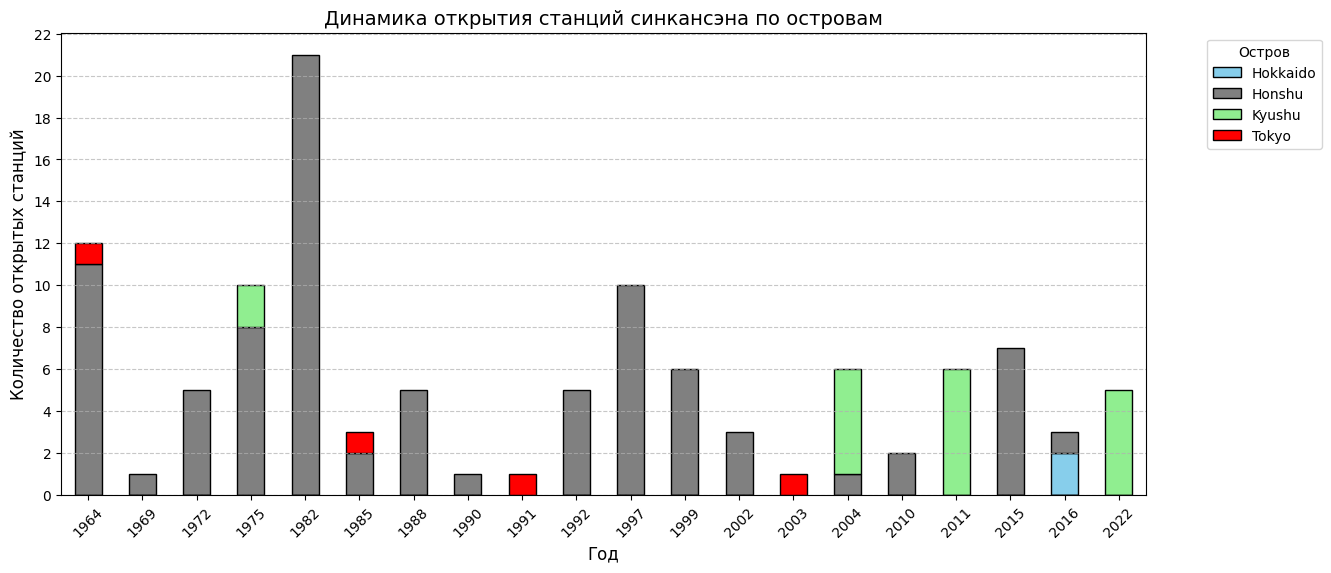

In [13]:
def island(pref):
    if pref == "Tokyo":
        return "Tokyo"
    elif pref in hokkaido:
        return "Hokkaido"
    elif pref in kyushu:
        return "Kyushu"
    elif pref in shikoku:
        return "Shikoku"
    elif pref in honshu:
        return "Honshu"
    else:
        return "Other"

df["Island"] = df["Prefecture"].apply(island)

stations_per_year_island = df.groupby(["Year", "Island"])["Station_Name"].count().unstack(fill_value=0)

stations_per_year_island.plot(
    kind="bar",
    stacked=True,
    figsize=(14,6),
    color={
        "Tokyo": "red",
        "Honshu": "gray",
        "Hokkaido": "skyblue",
        "Kyushu": "lightgreen",
        "Shikoku": "orange",
        "Other": "lightgray"
    },
    edgecolor="black"
)

plt.title("Динамика открытия станций синкансэна по островам", fontsize=14)
plt.xlabel("Год", fontsize=12)
plt.ylabel("Количество открытых станций", fontsize=12)

plt.xticks(rotation=45)
plt.yticks(np.arange(0, stations_per_year_island.sum(axis=1).max() + 2, 2))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Остров", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


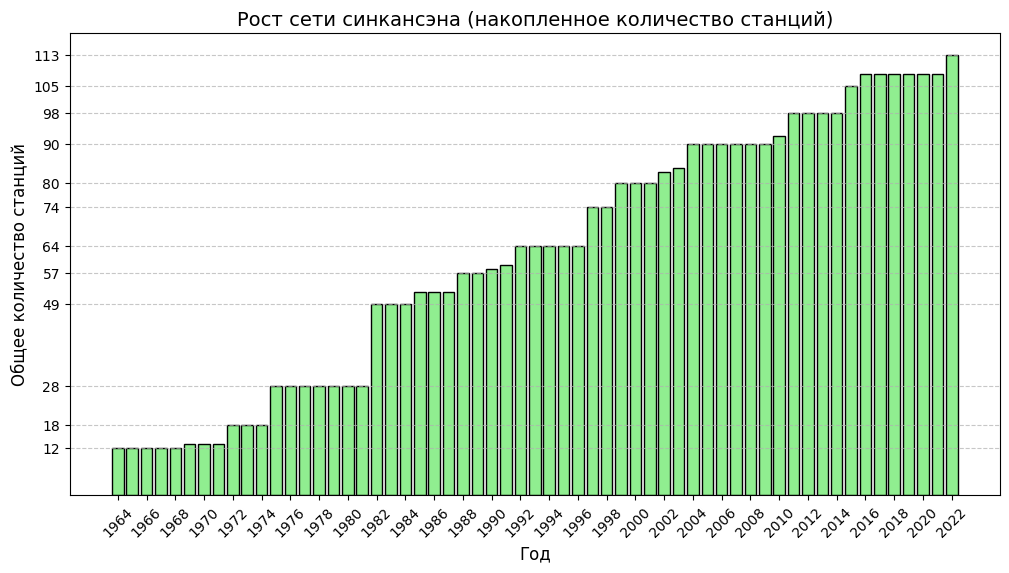

In [14]:
stations_per_year = df.groupby("Year")["Station_Name"].count()

years = np.arange(df["Year"].min(), df["Year"].max()+1)

stations_per_year_full = stations_per_year.reindex(years, fill_value=0)

cumulative_stations = stations_per_year_full.cumsum()

plt.figure(figsize=(12,6))
plt.bar(cumulative_stations.index, cumulative_stations.values, color="lightgreen", edgecolor="black")

plt.title("Рост сети синкансэна (накопленное количество станций)", fontsize=14)
plt.xlabel("Год", fontsize=12)
plt.ylabel("Общее количество станций", fontsize=12)

plt.xticks(years[::2], rotation=45)

plt.yticks(cumulative_stations.unique()[np.concatenate([[True], np.diff(cumulative_stations.unique()) >= 4])])

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Распределение станций по префектурам, цветом сделано распределение по островам, отдельно выделен Токио

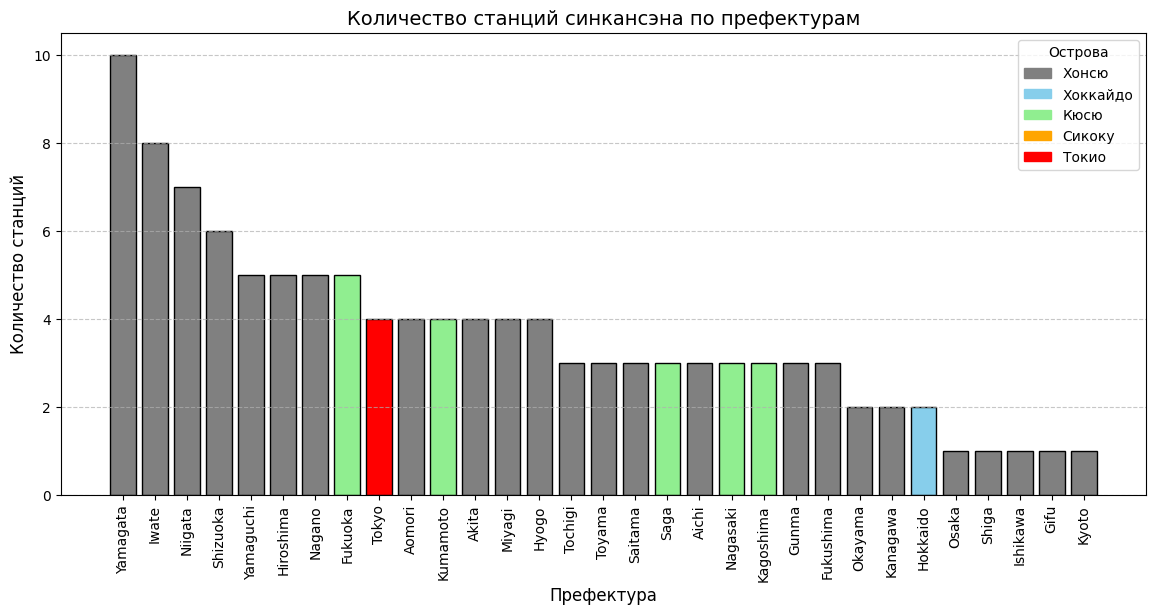

In [15]:
stations_per_pref = df.groupby("Prefecture")["Station_Name"].count().sort_values(ascending=False)


colors = []
for pref in stations_per_pref.index:
    if pref == "Tokyo":
        colors.append("red")
    elif pref in hokkaido:
        colors.append("skyblue")
    elif pref in kyushu:
        colors.append("lightgreen")
    elif pref in shikoku:
        colors.append("orange")
    elif pref in honshu:
        colors.append("gray")
    else:
        colors.append("lightgray")

plt.figure(figsize=(14,6))
plt.bar(stations_per_pref.index, stations_per_pref.values, color=colors, edgecolor="black")

plt.title("Количество станций синкансэна по префектурам", fontsize=14)
plt.xlabel("Префектура", fontsize=12)
plt.ylabel("Количество станций", fontsize=12)

plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
legend_elements = [
    mpatches.Patch(color="gray", label="Хонсю"),
    mpatches.Patch(color="skyblue", label="Хоккайдо"),
    mpatches.Patch(color="lightgreen", label="Кюсю"),
    mpatches.Patch(color="orange", label="Сикоку"),
    mpatches.Patch(color="red", label="Токио")
]
plt.legend(handles=legend_elements, title="Острова", loc="upper right")

plt.show()

#### Распределение станций по линиям Синкансена

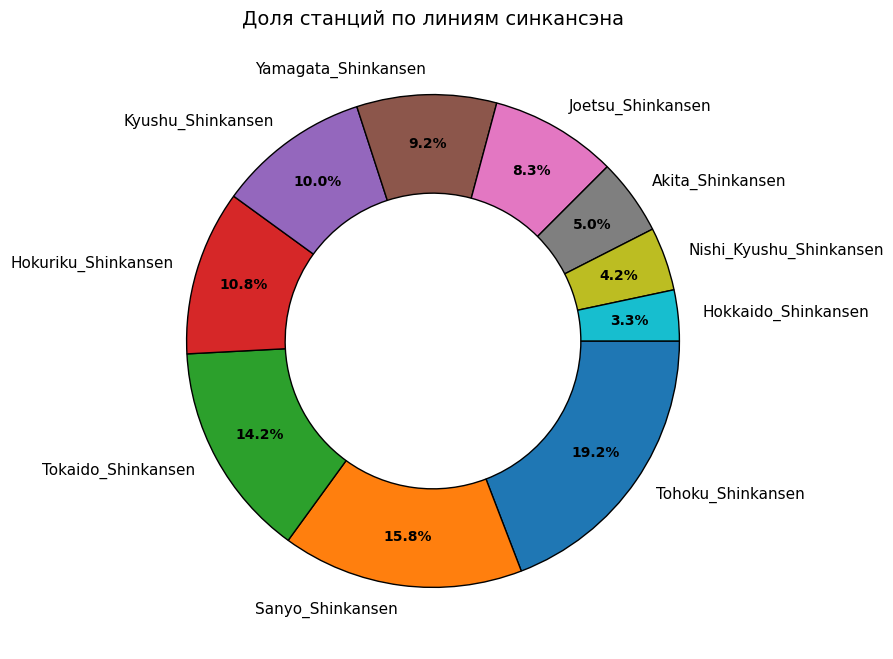

In [16]:
expanded_df = df.assign(
    Shinkansen_Line=df["Shinkansen_Line"].str.split(",")
).explode("Shinkansen_Line")

expanded_df["Shinkansen_Line"] = expanded_df["Shinkansen_Line"].str.strip()

stations_per_line = expanded_df["Shinkansen_Line"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    stations_per_line,
    labels=stations_per_line.index,
    autopct='%1.1f%%',
    startangle=0,
    counterclock=False,
    pctdistance=0.8,
    wedgeprops=dict(width=0.4, edgecolor='black')
)

plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=11)

plt.title("Доля станций по линиям синкансэна", fontsize=14)
plt.show()


#### Среднее расстояние между станциями на каждой линии Синкансена

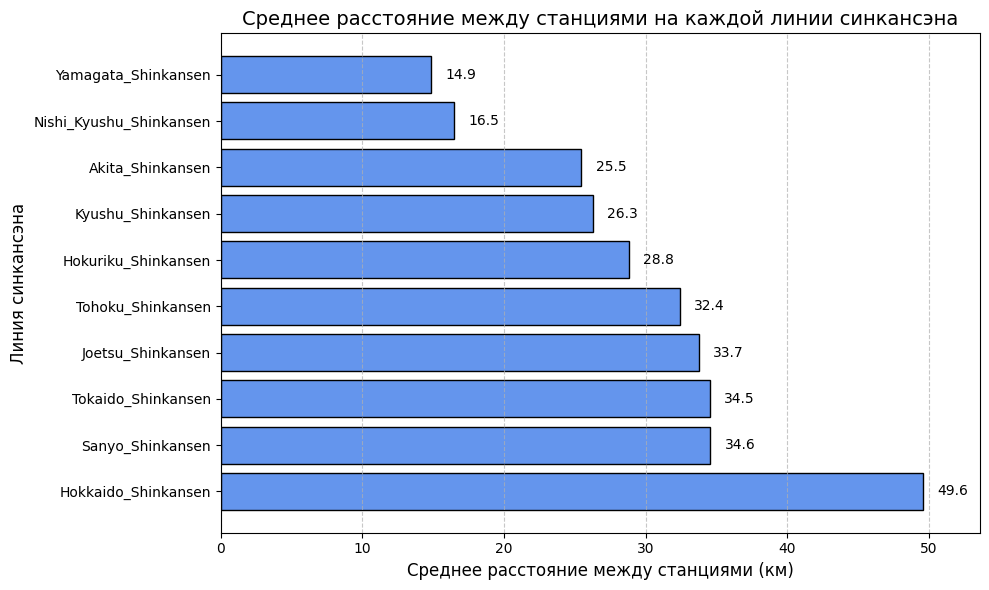

In [21]:
avg_distances = {}

for line, group in expanded_df.groupby("Shinkansen_Line"):
    group_sorted = group.sort_values("Distance from Tokyo st")
    distances = np.diff(group_sorted["Distance from Tokyo st"].values)
    if len(distances) > 0:
        avg_distances[line] = np.mean(distances)

avg_distances_df = pd.DataFrame.from_dict(avg_distances, orient="index", columns=["Avg_distance_km"])
avg_distances_df = avg_distances_df.sort_values("Avg_distance_km", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(avg_distances_df.index, avg_distances_df["Avg_distance_km"],
         color="cornflowerblue", edgecolor="black")

plt.title("Среднее расстояние между станциями на каждой линии синкансэна", fontsize=14)
plt.xlabel("Среднее расстояние между станциями (км)", fontsize=12)
plt.xlim(0, avg_distances_df["Avg_distance_km"].max() + 4)
plt.ylabel("Линия синкансэна", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.7)

for i, v in enumerate(avg_distances_df["Avg_distance_km"]):
    plt.text(v + 1, i, f"{v:.1f}", va='center', fontsize=10)


plt.tight_layout()
plt.show()

H0 (нулевая гипотеза): расстояние между соседними станциями не зависит от удалённости от Токио.
H1 (альтернативная гипотеза): чем дальше от Токио, тем больше среднее расстояние между станциями.

Как это проверить

Для каждой линии возьмём станции, отсортированные по расстоянию от Токио.

Посчитаем расстояния между соседними станциями.

Для каждой пары соседних станций возьмём:

расстояние между ними (gap)

среднюю удалённость от Токио (mean_distance)


In [22]:
records = []

for line in np.unique(expanded_df["Shinkansen_Line"]):
    line_mask = expanded_df["Shinkansen_Line"] == line
    line_dist = np.sort(expanded_df.loc[line_mask, "Distance from Tokyo st"].to_numpy())
    
    if line_dist.size > 1:
        gaps = np.diff(line_dist)
        mids = (line_dist[:-1] + line_dist[1:]) / 2
        records.append(np.column_stack((mids, gaps)))
records = np.vstack(records)

mean_distance = records[:, 0]
gaps = records[:, 1]

r, p = pearsonr(mean_distance, gaps)

print(f"Коэффициент корреляции Пирсона: r = {r:.3f}")
print(f"p-value = {p:.4f}")

Коэффициент корреляции Пирсона: r = 0.007
p-value = 0.9420


H₀ (нулевая гипотеза): средние расстояния между станциями одинаковы на всех островах (разницы нет).

H₁ (альтернативная): хотя бы на одном острове среднее расстояние отличается (то есть плотность станций разная).

Определить, к какому острову относится каждая станция.

Рассчитать расстояния между соседними станциями (Gap) внутри каждой линии.

Построить boxplot (ящик с усами) по островам

Применить однофакторный ANOVA-тест

<Figure size 800x500 with 0 Axes>

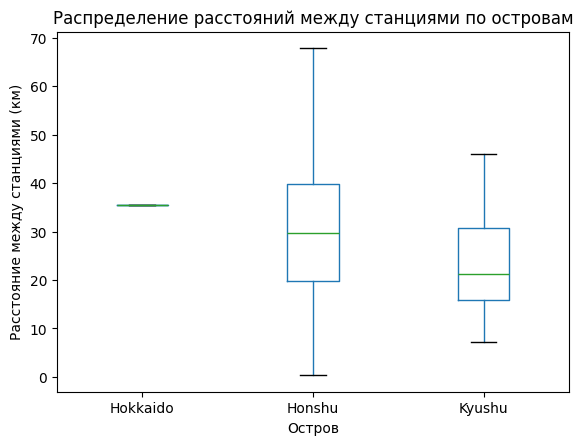

F-статистика = 1.588, p-value = 0.2093
Outliers:


,Shinkansen_Line,Island,Gap,Station_A,Station_B
6,Hokkaido_Shinkansen,Honshu,74.8,Okutsugaru-Imabetsu,Kikonai
61,Sanyo_Shinkansen,Kyushu,67.2,Kokura,Hakata


In [23]:
def island(pref):
    if pref in honshu: return "Honshu"
    if pref in hokkaido: return "Hokkaido"
    if pref in kyushu: return "Kyushu"
    return "Other"

df["Island"] = df["Prefecture"].apply(island)
records = []
for line in np.unique(expanded_df["Shinkansen_Line"]):
    line_mask = expanded_df["Shinkansen_Line"] == line
    line_dist = np.sort(expanded_df.loc[line_mask, "Distance from Tokyo st"].to_numpy())
    if line_dist.size > 1:
        gaps = np.diff(line_dist)
        mids = (line_dist[:-1] + line_dist[1:]) / 2
        prefs = expanded_df.loc[line_mask].sort_values("Distance from Tokyo st")["Prefecture"].to_numpy()
        mids_pref = prefs[:-1]
        islands = np.vectorize(island)(mids_pref)
        records.append(pd.DataFrame({"Island": islands, "Gap": gaps}))

gaps_df = pd.concat(records, ignore_index=True)

gaps_df = gaps_df.loc[~(
    
    ((gaps_df["Island"] == "Kyushu") & (gaps_df["Gap"] > 65)) | (gaps_df["Island"] == "Honshu") & (gaps_df["Gap"] > 70)
)].reset_index(drop=True)

plt.figure(figsize=(8,5))
gaps_df.boxplot(column="Gap", by="Island", grid=False)
plt.title("Распределение расстояний между станциями по островам")
plt.suptitle("")
plt.xlabel("Остров")
plt.ylabel("Расстояние между станциями (км)")
plt.show()
groups = [g["Gap"].to_numpy() for _, g in gaps_df.groupby("Island")]
f_stat, p_value = f_oneway(*groups)

print(f"F-статистика = {f_stat:.3f}, p-value = {p_value:.4f}")

records = []
for line in np.unique(expanded_df["Shinkansen_Line"]):
    line_mask = expanded_df["Shinkansen_Line"] == line
    line_sorted = expanded_df.loc[line_mask].sort_values("Distance from Tokyo st")
    line_dist = line_sorted["Distance from Tokyo st"].to_numpy()
    line_stations = line_sorted["Station_Name"].to_numpy()
    line_prefs = line_sorted["Prefecture"].to_numpy()
    
    if line_dist.size > 1:
        gaps = np.diff(line_dist)
        station_pairs = list(zip(line_stations[:-1], line_stations[1:]))
        islands = np.vectorize(island)(line_prefs[:-1])
        records.append(pd.DataFrame({
            "Shinkansen_Line": line,
            "Island": islands,
            "Gap": gaps,
            "Station_A": [a for a, _ in station_pairs],
            "Station_B": [b for _, b in station_pairs]
        }))



gaps_df = pd.concat(records, ignore_index=True)

outliers = []

for island, group in gaps_df.groupby("Island"):
    q1 = group["Gap"].quantile(0.25)
    q3 = group["Gap"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    mask = (group["Gap"] < lower) | (group["Gap"] > upper)
    outliers.append(group.loc[mask])

outliers_df = pd.concat(outliers)
print("Outliers:")
outliers_df.sort_values("Gap", ascending=False).head(4)





Бонус (карта)

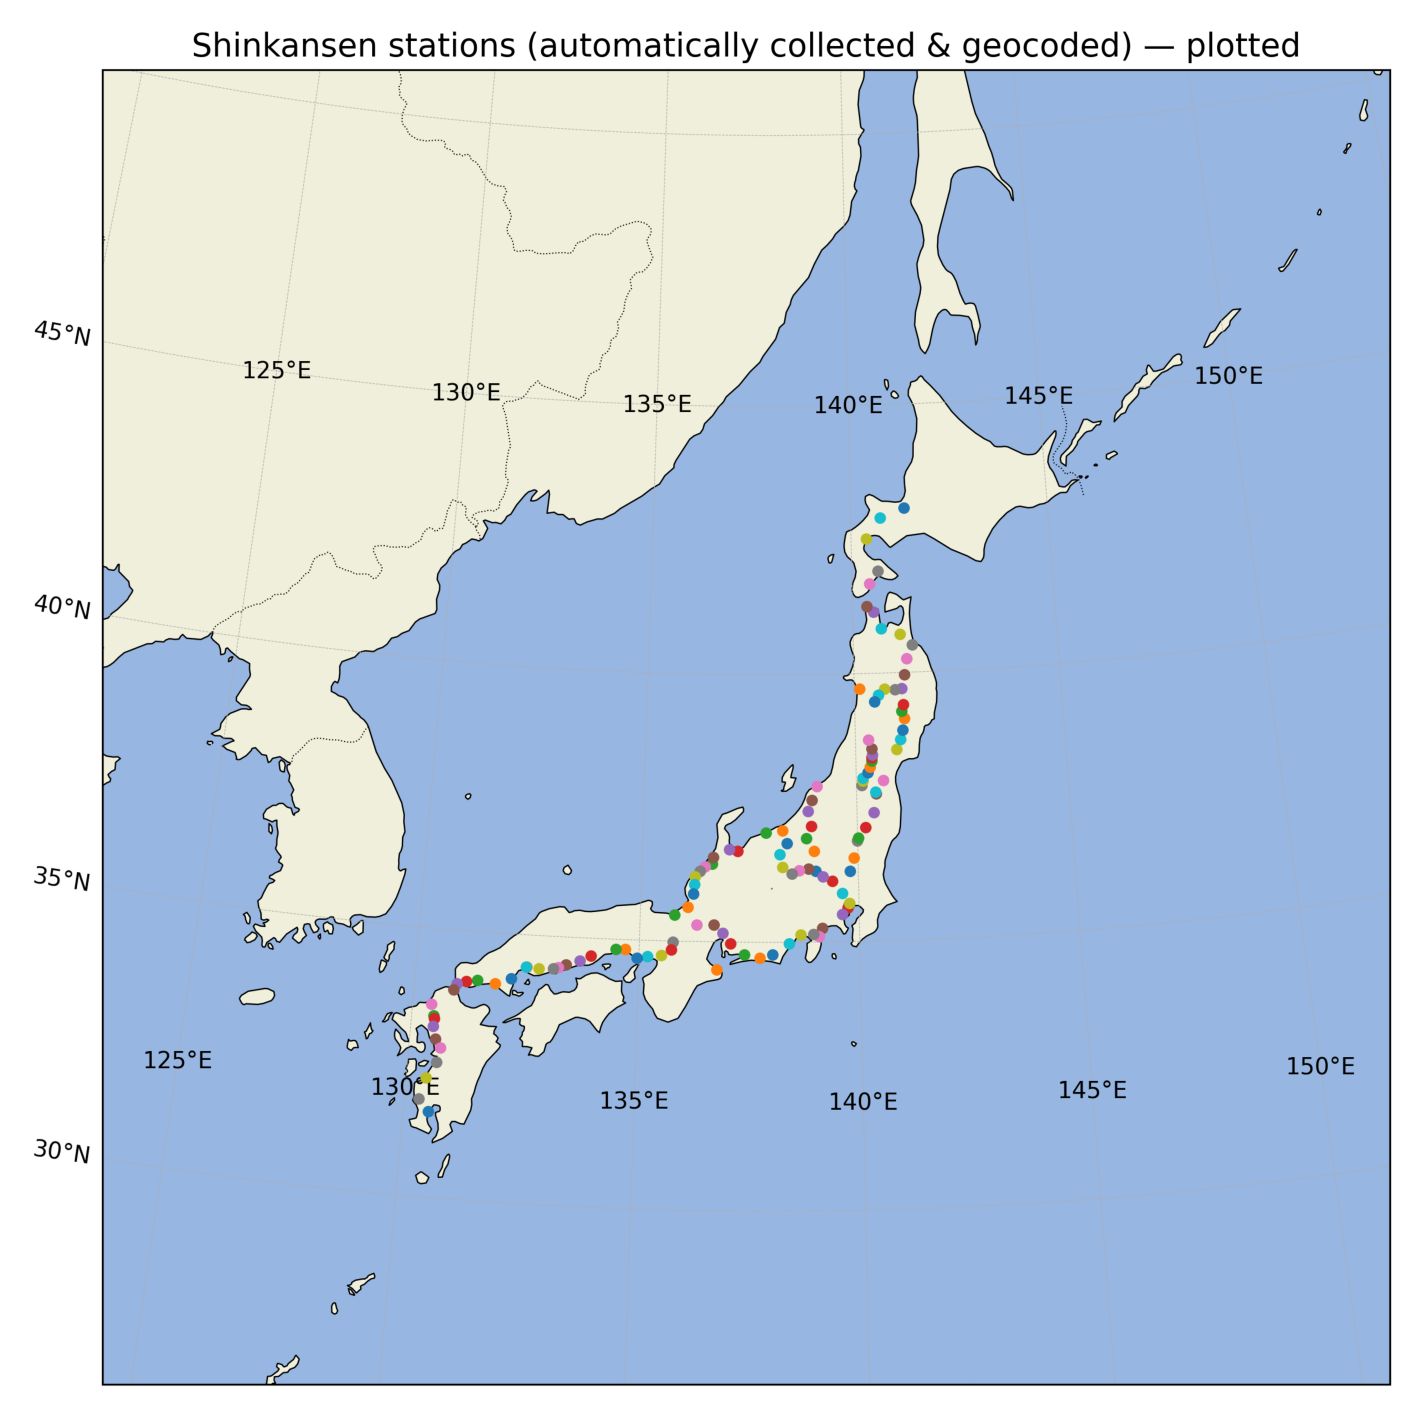

In [24]:
img = mpimg.imread("japan_shinkansen.png")
fig, ax = plt.subplots(figsize=(20, 12), dpi=150)
plt.imshow(img)
plt.axis("off")
plt.show()